In [1]:
from statistics import mean
import gensim.downloader as api
from gensim.models import KeyedVectors

In [2]:
# glove_wiki = api.load("glove-wiki-gigaword-100")
# glove_twitter = api.load("glove-twitter-100")
# glove_wiki.save("glove-wiki-gigaword-100")
# glove_twitter.save("glove-twitter-100")

In [3]:
glove_wiki = KeyedVectors.load("glove-wiki-gigaword-100")
glove_twitter = KeyedVectors.load("glove-twitter-100")
print(glove_wiki, glove_twitter)

KeyedVectors<vector_size=100, 400000 keys> KeyedVectors<vector_size=100, 1193514 keys>


# Gender Direction Vector e Professional Bias

In [4]:
import numpy as np
from gensim.models import KeyedVectors

# 1. Definisci le coppie di parole di genere (Gender Pairs)
# Queste coppie dovrebbero essere neutre in termini di stereotipi sociali
# (cioè, la differenza dovrebbe riguardare solo il genere).
# Una lista standard usata nella ricerca (es. Bolukbasi et al., 2016):
GENDER_PAIRS = [
    ('woman', 'man'),
    ('girl', 'boy'),
    ('she', 'he'),
    ('mother', 'father'),
    ('sister', 'brother'),
    ('aunt', 'uncle'),
    ('niece', 'nephew'),
    ('daughter', 'son'),
    ('female', 'male'),
    ('her', 'his')
]

def calculate_gender_direction_vector(embedding_model: KeyedVectors, pairs: list) -> np.ndarray:
    gender_difference_vectors = []

    # 2. Iterare sulle coppie e calcolare la differenza (V_femminile - V_maschile)
    for female_word, male_word in pairs:
        if female_word in embedding_model and male_word in embedding_model:
            # Calcola la differenza vettoriale: V_femminile - V_maschile
            diff_vector = embedding_model[female_word] - embedding_model[male_word]
            gender_difference_vectors.append(diff_vector)

    # 3. Calcolare il vettore medio (l'asse di genere non normalizzato)
    mean_gender_vector = np.mean(gender_difference_vectors, axis=0)
    print(mean_gender_vector)

    # 4. Normalizzare il vettore per avere lunghezza 1
    # Questo è importante per rendere i calcoli di proiezione (dot product/cosine similarity) comparabili
    normalized_gender_vector = mean_gender_vector / np.linalg.norm(mean_gender_vector)

    return normalized_gender_vector


gender_vector_twitter = calculate_gender_direction_vector(glove_twitter, GENDER_PAIRS)
gender_vector_wiki = calculate_gender_direction_vector(glove_wiki, GENDER_PAIRS)


[-0.29476708 -0.1494952  -0.0753357   0.11394221 -0.19019495 -0.41332522
  0.4642617  -0.1925564   0.06776236 -0.2812038  -0.481256    0.08646961
 -0.23363003 -0.21704884 -0.2233259   0.28994295 -0.20534174 -0.03108959
 -0.17987269  0.29669046  0.263885   -0.29658058 -0.3793438   0.29260048
  0.0574257   0.90287197  0.0415634  -0.033846    0.2039973   0.540316
  0.04629481 -0.3349227   0.05775946  0.04481741 -0.2913616   0.04710999
  0.1396172   0.134666    0.014916    0.4191959  -0.00933101 -0.0052823
  0.43820614 -0.1277183  -0.07322508  0.3297972   0.3536194  -0.2270009
 -0.1122386  -0.00425757 -0.12906529 -0.26264212 -0.3322797  -0.33556512
  0.27144808  0.08020119 -0.22237709 -0.01403049 -0.07971308  0.34705898
  0.09837399  0.31189257 -0.10968451  0.07783121 -0.43079883  0.27838004
 -0.24208629 -0.01934734  0.4667222   0.05457797 -0.05089797  0.0199694
 -0.07246564 -0.46033606 -0.252856   -0.0565118   0.15309606 -0.22431059
  0.15848511 -0.1833792   0.34229004 -0.05064646 -0.1315

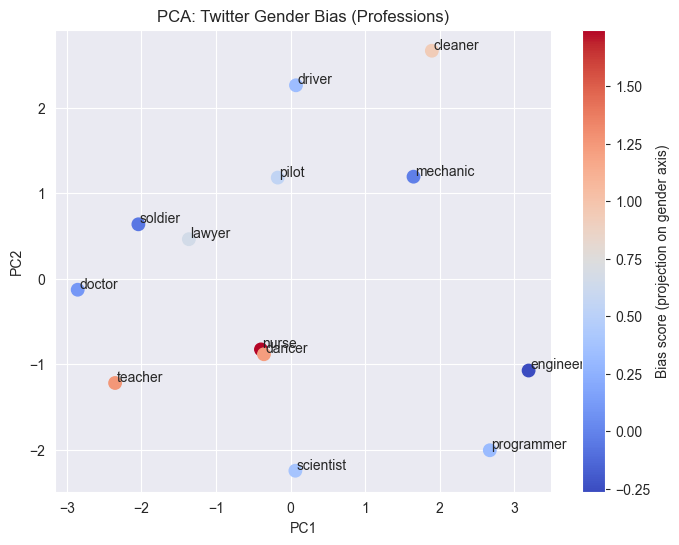


Twitter Embeddings
PC1 alignment with gender direction: -0.0795 (explains 19.41% variance)
PC2 alignment with gender direction: -0.0412 (explains 12.84% variance)


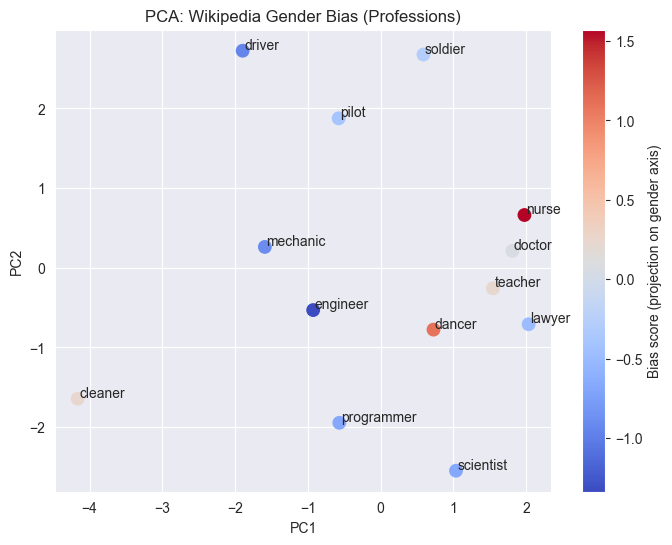


Wikipedia Embeddings
PC1 alignment with gender direction: 0.1617 (explains 18.63% variance)
PC2 alignment with gender direction: -0.0132 (explains 15.16% variance)


In [2]:
import numpy as np
from gensim.models import KeyedVectors
from typing import List, Dict

professions = ['doctor', 'nurse', 'engineer', 'teacher', 'programmer', 'scientist', 'soldier', 'pilot', 'dancer', 'driver', 'mechanic', 'lawyer', 'cleaner']

def calculate_projection_bias_scores(
    embedding_model: KeyedVectors,
    gender_vector: np.ndarray,
    professions: List[str]
) -> Dict[str, float]:
    bias_scores = {}
    normalized_gender_vector = gender_vector / np.linalg.norm(gender_vector)

    for profession in professions:
        if profession in embedding_model:
            # 1. Ottieni il vettore della professione (P)
            P_vector = embedding_model[profession]

            # 2. Calcola il Bias Score tramite il prodotto scalare (proiezione)
            # Nota: La somiglianza del coseno tra un vettore normalizzato e un altro vettore
            # (anche se non normalizzato) è il prodotto scalare.
            bias_score = np.dot(P_vector, normalized_gender_vector)

            bias_scores[profession] = bias_score

    return bias_scores


results_twitter = calculate_projection_bias_scores(glove_twitter, gender_vector_twitter, professions)
results_wiki = calculate_projection_bias_scores(glove_wiki, gender_vector_wiki, professions)
sorted_results_twitter= sorted(results_twitter.items(), key=lambda item: item[1], reverse=True)
sorted_results_wiki = sorted(results_wiki.items(), key=lambda item: item[1], reverse=True)

print("Bias Scores (Twitter):")
for profession, score in sorted_results_twitter:
    print(f"  {profession.capitalize():<12}: {score:.4f}")

print("\nBias Scores (Wikipedia):")
for profession, score in sorted_results_wiki:
    print(f"  {profession.capitalize():<12}: {score:.4f}")



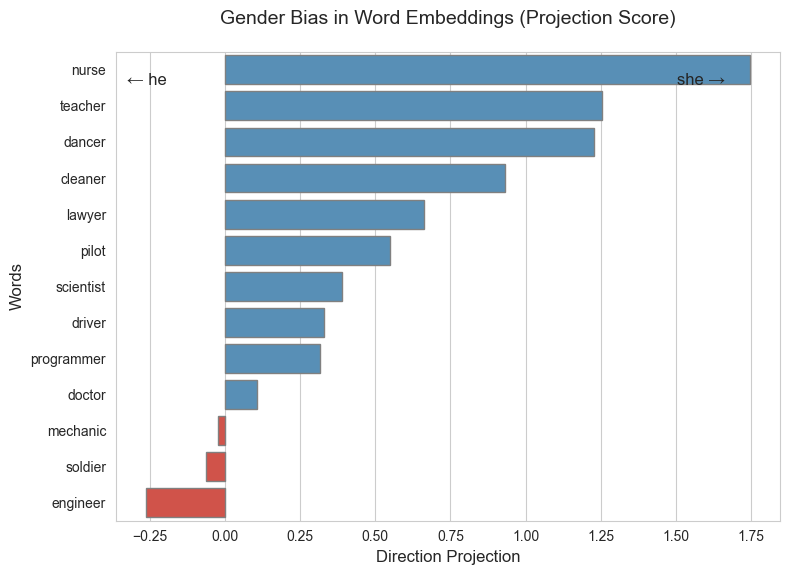

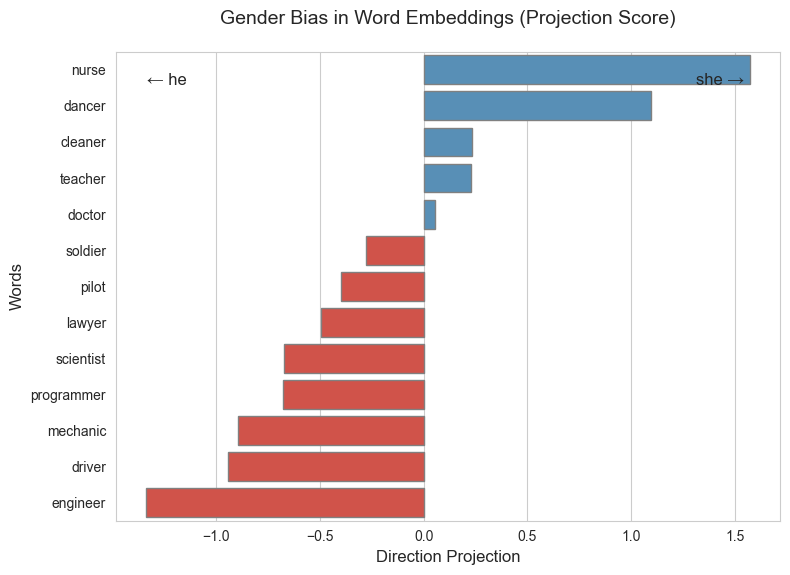

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from typing import Dict, List

def plot_gender_bias_v2(
    bias_scores: Dict[str, float],
    title: str = "Gender Bias in Word Embeddings (Projection Score)",
    he_label: str = "← he",
    she_label: str = "she →"
):
    """
    Crea un grafico a barre di polarizzazione, risolvendo il DeprecationWarning di Seaborn.
    """

    # 1. Preparazione dei dati: Converti in DataFrame
    df = pd.DataFrame(list(bias_scores.items()), columns=['Word', 'Score'])

    # Crea la nuova colonna 'Gender Association' per il parametro hue
    df['Gender_Association'] = df['Score'].apply(
        lambda x: 'Female-Associated' if x >= 0 else 'Male-Associated'
    )

    # Ordina il DataFrame in base al punteggio
    df = df.sort_values(by='Score', ascending=False)

    # 2. Imposta lo stile del grafico
    sns.set_style("whitegrid")
    plt.figure(figsize=(8, len(df) * 0.45))

    # 3. Definisci una mappatura colori esplicita (blu per female, rosso per male)
    # Questa mappa sostituisce la tavolozza 'RdBu' definita automaticamente prima
    color_map = {
        'Female-Associated': sns.color_palette("Blues_d")[2],  # Tonalità di blu per 'she'
        'Male-Associated': sns.color_palette("Reds_d")[2]      # Tonalità di rosso/arancione per 'he'
    }

    # 4. Crea il grafico a barre usando 'hue' e impostando 'legend=False'
    ax = sns.barplot(
        x='Score',
        y='Word',
        data=df,
        hue='Gender_Association',      # ASSEGNA IL GRUPPO A HUE
        palette=color_map,             # USA LA TAVOLOZZA DEFINITA
        legend=False,                  # RIMUOVI LA LEGGENDA (come richiesto dal warning)
        dodge=False,                   # Assicura che le barre non siano affiancate
        edgecolor='gray'
    )

    # 5. Personalizzazione estetica
    ax.xaxis.grid(True)
    ax.yaxis.grid(False)
    ax.set_xlabel("Direction Projection", fontsize=12)
    ax.set_ylabel("Words", fontsize=12)
    ax.tick_params(axis='y', labelsize=10)

    # Inserisce le etichette "he" e "she" nella parte superiore
    plt.title(title, fontsize=14, pad=20)
    ax.text(ax.get_xlim()[0] * 0.9, ax.get_ylim()[1] + 1, he_label,
            ha='left', va='bottom', fontsize=12)
    ax.text(ax.get_xlim()[1] * 0.9, ax.get_ylim()[1] + 1, she_label,
            ha='right', va='bottom', fontsize=12)

    plt.tight_layout()
    plt.show()
plot_gender_bias_v2(results_twitter)
plot_gender_bias_v2(results_wiki)

In [7]:
positive_traits = [
    "resilient", "determined", "optimistic", "generous", "adaptable", "persistent",
    "entrepreneurial", "educated", "innovative", "influential"
]

negative_traits = [
    "criminal", "lazy", "ignorant", "dirty", "dangerous", "uneducated",
    "hopeless", "desperate", "helpless", "dependent", "excluded",
    "vulnerable", "unskilled", "unfortunate", "marginalized", "powerless",
    "greedy", "arrogant", "shallow", "egocentric", "corrupt"
]

target_words = ["poor", "rich"]

def calculate_association_scores(
    embedding_model: KeyedVectors,
    target_words: List[str],
    positive_traits: List[str],
    negative_traits: List[str]
) -> Dict[str, float]:

    positive_similarities = [
        embedding_model.similarity(target_word, trait) for trait in positive_traits for target_word in target_words if trait in embedding_model and target_word in embedding_model
    ]
    positive_association = mean(positive_similarities) if positive_similarities else 0.0

    negative_similarities = [
        embedding_model.similarity(target_word, trait) for trait in negative_traits for target_word in target_words if trait in embedding_model and target_word in embedding_model
    ]
    negative_association = mean(negative_similarities) if negative_similarities else 0.0

    difference = negative_association - positive_association

    return {
        'positive_association': positive_association
        , 'negative_association': negative_association
        , 'difference': difference
    }


print('POOR:', calculate_association_scores(glove_twitter, ["poor"], positive_traits, negative_traits))
print('RICH:', calculate_association_scores(glove_twitter, ["rich"], positive_traits, negative_traits))

results = {
    'POOR': calculate_association_scores(glove_twitter, ["poor"], positive_traits, negative_traits),
    'RICH': calculate_association_scores(glove_twitter, ["rich"], positive_traits, negative_traits)
}

results1 = {
    'POOR': calculate_association_scores(glove_wiki, ["poor"], positive_traits, negative_traits),
    'RICH': calculate_association_scores(glove_wiki, ["rich"], positive_traits, negative_traits)
}


POOR: {'positive_association': 0.26696226, 'negative_association': 0.4092921, 'difference': 0.14232984}
RICH: {'positive_association': 0.367109, 'negative_association': 0.41526806, 'difference': 0.048159063}


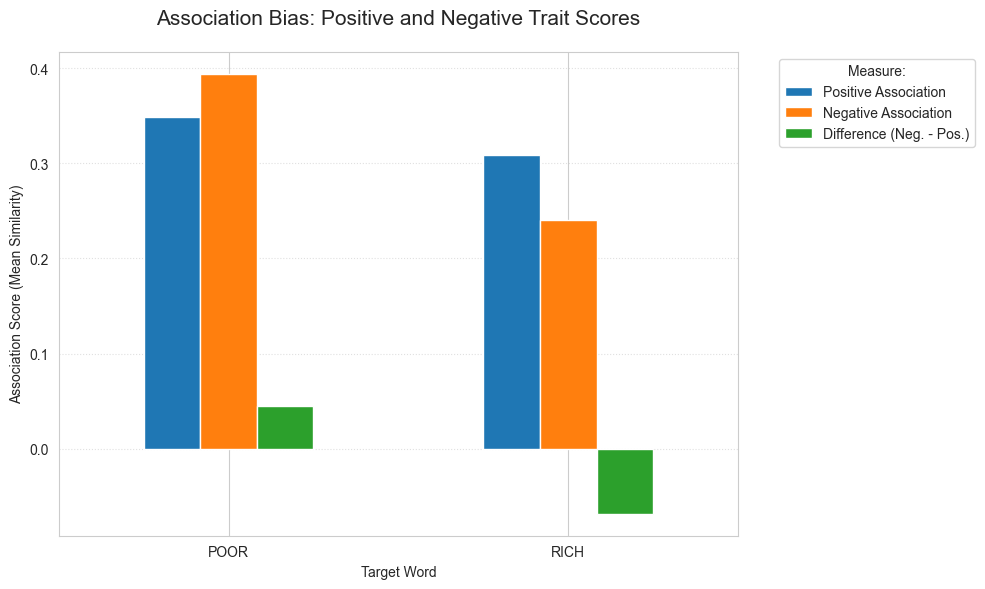

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_full_association_data_en(results: dict, title: str = "Association Bias: Positive and Negative Trait Scores"):
    """
    Creates a clustered bar chart to visualize positive association,
    negative association, and the difference score for each target word.

    :param results: A dictionary where keys are target words ('POOR', 'RICH')
                    and values are the output dictionaries from the
                    calculate_association_scores function.
    :param title: The chart title.
    """

    # 1. Prepare data for the DataFrame (Translate Italian keys to English)
    data_for_plot = {}
    for word, scores in results.items():
        data_for_plot[word] = {
            'Positive Association': scores['positive_association'],
            'Negative Association': scores['negative_association'],
            'Difference (Neg. - Pos.)': scores['difference']
        }

    df = pd.DataFrame.from_dict(data_for_plot, orient='index')

    # 2. Plotting
    fig, ax = plt.subplots(figsize=(10, 6))

    # Create the clustered bar chart
    df.plot(kind='bar', ax=ax, rot=0)

    # 3. Customization (All in English)
    ax.set_title(title, fontsize=15, pad=20)
    ax.set_ylabel("Association Score (Mean Similarity)")
    ax.set_xlabel("Target Word")

    # Add a legend
    ax.legend(title='Measure:', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

#plot_full_association_data_en(results)
plot_full_association_data_en(results1)


# ROBA MIA

In [9]:
male_words = ['man', 'men', 'he']
female_words = ['woman', 'women', 'she']
black_words = ['black', 'african', 'dark', 'afro']
white_words = ['white', 'caucasian', 'light', 'european']

# Stereotype attributes
career_words = ['engineer', 'scientist', 'doctor', 'manager', 'boss', 'leader','rich', 'salary', 'office']
family_words = [
    'home', 'household', 'children', 'family', 'parents', 'caring', 'nurturing', 'cook', 'cooking'
]
positive_traits = ['successful', 'educated', 'happy', 'leader']
negative_traits = ['rich', 'arrogant', 'selfish', 'greedy']



In [10]:
glove_wiki.similar_by_word("men")

[('women', 0.8612374663352966),
 ('boys', 0.7152392268180847),
 ('others', 0.7086237072944641),
 ('soldiers', 0.7079963684082031),
 ('girls', 0.7069588303565979),
 ('they', 0.696332573890686),
 ('pair', 0.6923261284828186),
 ('four', 0.6805620789527893),
 ('three', 0.6797769069671631),
 ('man', 0.6719298958778381)]

In [11]:
emb_difference = glove_twitter['she'] - glove_twitter['he']
print(emb_difference)

[-0.78411996 -0.29744998 -0.14886001 -0.19871    -0.18495001 -0.84749997
  0.84320605  0.13707     0.30008     0.01528001 -1.26882     0.33240002
 -1.0439     -0.45538002 -0.11872998  0.112929   -0.170522    0.00339
 -0.08478001  0.39769998 -0.1401     -0.67188305  0.17846999  0.20355001
 -0.173465    1.60487     0.11398998  0.27554998  0.26434     0.86704
 -0.03393999 -0.59896    -0.083047   -0.107821   -0.41901     0.03188002
 -0.08866999  0.17930001  0.2269      0.89593    -0.09377998 -0.140604
  0.34441     0.20994    -0.81391     0.67012995  0.19931    -0.62052
 -0.171684   -0.05936998 -0.35077    -0.351642   -0.508187   -0.475264
  0.58669     0.21724    -0.22055     0.16865999 -0.11765     0.04607001
 -0.04956001  0.41156802 -0.08441     0.31105    -1.14267    -0.13317528
 -0.36386     0.10380998  0.02769995  0.13143003  0.315155    0.28625998
 -0.449259   -0.75402    -0.37672102 -0.12261    -0.04871999  0.27789998
  0.70051    -0.456868    0.21070004  0.12257999 -0.49558398 -0.

In [12]:
import numpy as np
from gensim.models import KeyedVectors

# Load pre-trained word embeddings
# Replace with the path to your glove-wiki-gigaword-100 or glove-twitter-100 model

# Define gender-specific words
male_words = ['man', 'he', 'him', 'male']
female_words = ['woman', 'she', 'her', 'female']

# Define professional words
professions = ['doctor', 'nurse', 'engineer', 'teacher', 'programmer', 'homemaker', 'scientist', 'soldiers', 'pilot', 'dancer', 'driver']

# Calculate the gender direction vector
gender_direction = np.mean([glove_twitter[w] for w in male_words], axis=0) - np.mean([glove_twitter[w] for w in female_words], axis=0)

# print("Gender Direction Vector:")
# print(gender_direction)

# Calculate similarity of professions to male and female words
for profession in professions:
    if profession in glove_twitter:
        man_career_twitter = np.mean([glove_twitter.similarity(m, profession) for m in male_words])
        woman_career_twitter = np.mean([glove_twitter.similarity(w, profession) for w in female_words])
        man_career_wiki = np.mean([glove_wiki.similarity(m, profession) for m in male_words])
        woman_career_wiki = np.mean([glove_wiki.similarity(w, profession) for w in female_words])

        print(f"\n{profession.capitalize()}:")
        print(f"  Similarity to 'he': {man_career_twitter:.4f}")
        print(f"  Similarity to 'she': {woman_career_twitter:.4f}")
        print(f"  Difference (He - She) Twitter: {man_career_twitter - woman_career_twitter:.4f}")

        print(f"  Similarity to 'he' Wiki: {man_career_wiki:.4f}")
        print(f"  Similarity to 'she' Wiki: {woman_career_wiki:.4f}")
        print(f"  Difference (He - She) Wiki: {man_career_wiki - woman_career_wiki:.4f}")


Doctor:
  Similarity to 'he': 0.4647
  Similarity to 'she': 0.4633
  Difference (He - She) Twitter: 0.0015
  Similarity to 'he' Wiki: 0.5284
  Similarity to 'she' Wiki: 0.5431
  Difference (He - She) Wiki: -0.0147

Nurse:
  Similarity to 'he': 0.3013
  Similarity to 'she': 0.4006
  Difference (He - She) Twitter: -0.0993
  Similarity to 'he' Wiki: 0.4053
  Similarity to 'she' Wiki: 0.5220
  Difference (He - She) Wiki: -0.1167

Engineer:
  Similarity to 'he': 0.2423
  Similarity to 'she': 0.2070
  Difference (He - She) Twitter: 0.0353
  Similarity to 'he' Wiki: 0.3361
  Similarity to 'she' Wiki: 0.2956
  Difference (He - She) Wiki: 0.0405

Teacher:
  Similarity to 'he': 0.4695
  Similarity to 'she': 0.5402
  Difference (He - She) Twitter: -0.0707
  Similarity to 'he' Wiki: 0.4861
  Similarity to 'she' Wiki: 0.5368
  Difference (He - She) Wiki: -0.0506

Programmer:
  Similarity to 'he': 0.1255
  Similarity to 'she': 0.1491
  Difference (He - She) Twitter: -0.0236
  Similarity to 'he' Wik

In [13]:

# Words for the group "POOR"
poor_negative_words = ["criminal", "lazy", "ignorant", "dirty", "dangerous", "uneducated"]
poor_positive_words = [
    "resilient", "determined", "optimistic", "generous", "adaptable","persistent"]

# Words for the group "RICH"
rich_negative_words = ["greedy", "arrogant", "shallow", "egocentric", "corrupt"]
rich_positive_words = ["generous", "entrepreneurial", "educated", "innovative", "influential"]

scientist_positive_words = [
    "intelligent", "innovative", "curious", "dedicated", "creative",
    "knowledgeable", "hardworking", "respected", "visionary", "ethical"
]

poor_negative_words.extend([
    "hopeless", "desperate", "helpless", "dependent", "excluded",
    "vulnerable", "unskilled", "unfortunate", "marginalized", "powerless"
])




poor_negative_twitter = mean([glove_twitter.similarity(p, "poor") for p in poor_negative_words])
poor_positive_twitter = mean([glove_twitter.similarity(p, "poor") for p in poor_positive_words])
print(f"POOR association with negative traits (twitter): {poor_negative_twitter}")
print(f"POOR association with positive traits (twitter): {poor_positive_twitter}")
print(f"Difference (Negative - Positive) POOR (twitter): {poor_negative_twitter - poor_positive_twitter}")

rich_negative_twitter = mean([glove_twitter.similarity(r, "rich") for r in rich_negative_words])
rich_positive_twitter = mean([glove_twitter.similarity(r, "rich") for r in rich_positive_words ])
print(f"\nRICH association with negative traits (twitter): {rich_negative_twitter}")
print(f"RICH association with positive traits (twitter): {rich_positive_twitter}")
print(f"Difference (Negative - Positive) RICH (twitter): {rich_negative_twitter - rich_positive_twitter}")




POOR association with negative traits (twitter): 0.4196445345878601
POOR association with positive traits (twitter): 0.27376261353492737
Difference (Negative - Positive) POOR (twitter): 0.14588192105293274

RICH association with negative traits (twitter): 0.4486611783504486
RICH association with positive traits (twitter): 0.42546766996383667
Difference (Negative - Positive) RICH (twitter): 0.02319350838661194


In [14]:
import numpy as np
from sklearn.decomposition import PCA
from gensim.models.keyedvectors import KeyedVectors

# 1. CARICAMENTO DATI (SOSTITUISCI IL PATH!)
# Assumi che 'glove_twitter.bin' sia il tuo modello GloVe convertito
wv = glove_twitter  # KeyedVectors.load("glove_twitter")

# 2. DEFINIZIONE DEL BIAS (Ricchi/Poveri e Positivo/Negativo)
# Le coppie (Positivo, Negativo) definiscono la direzione del bias
BIAS_PAIRS = [
    ('rich', 'poor'), ('wealth', 'poverty'), ('successful', 'unemployed'),
    ('happy', 'desperate'), ('genius', 'ignorant'), ('influential', 'marginalized')
]

# 3. VETTORI DI DIFFERENZA (La matrice D)
# Calcola: Vettore Positivo - Vettore Negativo
diff_vectors = []
for pos, neg in BIAS_PAIRS:
    try:
        diff_vectors.append(wv[pos] - wv[neg])
    except KeyError as e:
        # Ignora le parole non trovate nel vocabolario GloVe
        print(f"Parola '{e}' non trovata. Saltata.")

D = np.array(diff_vectors)

# 4. PCA: Trova la direzione del bias (PC1)
pca = PCA(n_components=1)
pca.fit(D)
bias_vector = pca.components_[0]

# 5. QUANTIFICAZIONE E VISUALIZZAZIONE
TEST_WORDS = ['doctor', 'janitor', 'CEO', 'waitress', 'banker', 'chef']

print("\n--- Punteggi di Bias (Ricchi/Poveri - Positivo/Negativo) ---")
print("Positivo: + Allineato con 'Richi' / 'Successo'")
print("Negativo: - Allineato con 'Poveri' / 'Insuccesso'")

for word in TEST_WORDS:
    try:
        # Punteggio = Prodotto Scalare (Proiezione del vettore della parola sulla PC1)
        score = np.dot(wv[word], bias_vector)
        print(f"{word.ljust(10)}: {score:.4f}")
    except KeyError:
        print(f"{word.ljust(10)}: NON TROVATO")


--- Punteggi di Bias (Ricchi/Poveri - Positivo/Negativo) ---
Positivo: + Allineato con 'Richi' / 'Successo'
Negativo: - Allineato con 'Poveri' / 'Insuccesso'
doctor    : 1.0923
janitor   : -0.5954
CEO       : NON TROVATO
waitress  : -0.5644
banker    : -0.9898
chef      : 0.3870


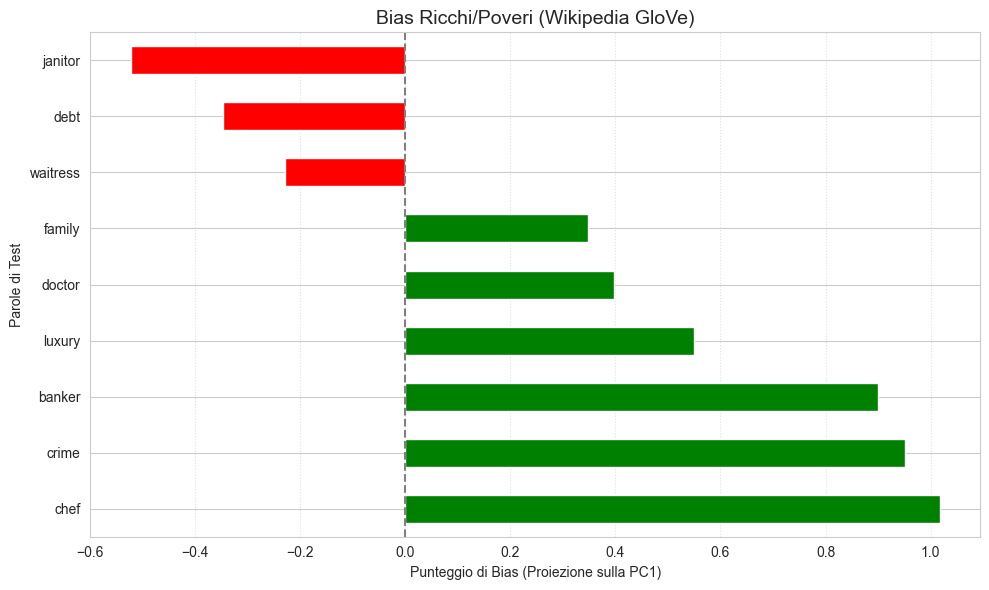

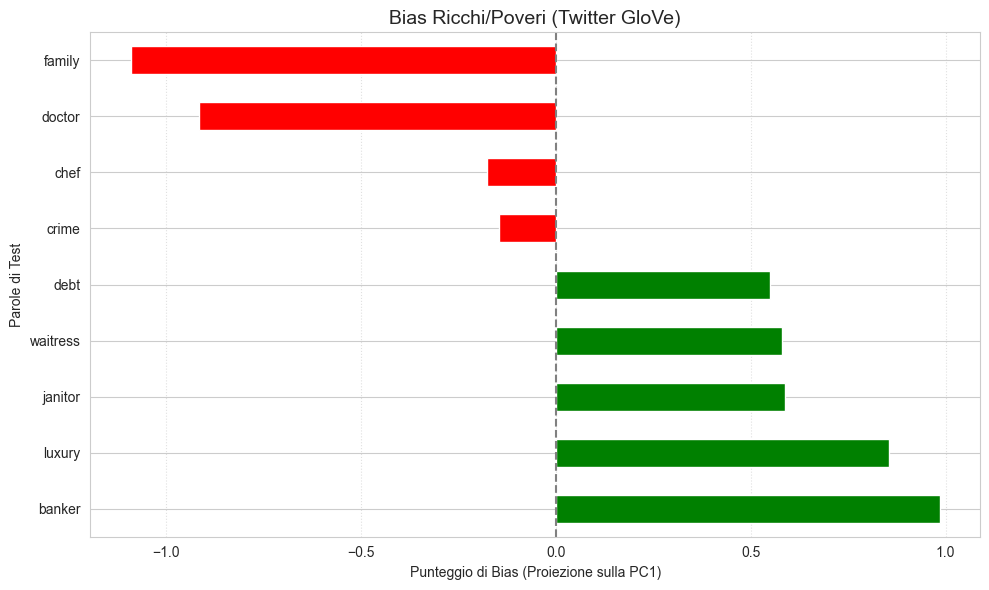

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models.keyedvectors import KeyedVectors

# ----------------------------------------------------------------------
# 1. FUNZIONE PER CREARE IL GRAFICO
# ----------------------------------------------------------------------

def plot_bias_scores(scores: pd.Series, title: str = "Bias Ricchi/Poveri (Proiezione su PC1)"):
    """
    Crea un grafico a barre che visualizza i punteggi di bias.

    Un punteggio positivo (a destra) indica allineamento con la polarità 'Ricchi'.
    Un punteggio negativo (a sinistra) indica allineamento con la polarità 'Poveri'.
    """
    # Ordina i valori per una visualizzazione più chiara
    scores = scores.sort_values(ascending=False)

    # Definisci i colori (positivo = verde, negativo = rosso)
    colors = ['green' if x > 0 else 'red' for x in scores]

    plt.figure(figsize=(10, 6))
    scores.plot(kind='barh', color=colors)

    # Aggiungi una linea centrale a zero per riferimento
    plt.axvline(x=0, color='gray', linestyle='--')

    plt.title(title, fontsize=14)
    plt.xlabel("Punteggio di Bias (Proiezione sulla PC1)")
    plt.ylabel("Parole di Test")
    plt.grid(axis='x', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# ----------------------------------------------------------------------
# 2. FUNZIONE PER CALCOLARE LA PCA E I PUNTEGGI (Versione ottimizzata)
# ----------------------------------------------------------------------

def calculate_pca_bias(wv: KeyedVectors):
    """Calcola la PC1 del bias e proietta le parole di test."""

    # 2a. DEFINIZIONE DEL BIAS (Coppie Positivo/Negativo)
    # Coppie che definiscono l'asse Ricchi/Poveri (Positivo, Negativo)
    BIAS_PAIRS = [
        ('rich', 'poor'), ('wealth', 'poverty'), ('successful', 'unemployed'),
        ('happy', 'desperate'), ('genius', 'ignorant'), ('influential', 'marginalized'),
        ('clean', 'dirty'), ('safe', 'dangerous'), ('educated', 'uneducated')
    ]

    # Professioni/Concetti da testare
    TEST_WORDS = ['doctor', 'janitor', 'CEO', 'waitress', 'banker', 'chef',
                  'luxury', 'debt', 'crime', 'family']

    # 2b. CREAZIONE DELLA MATRICE DI DIFFERENZA (D)
    diff_vectors = []

    for pos, neg in BIAS_PAIRS:
        try:
            diff_vectors.append(wv[pos] - wv[neg])
        except KeyError as e:
            pass # Ignora le parole non trovate

    if not diff_vectors:
        print("Errore: Nessun vettore di differenza valido è stato creato.")
        return pd.Series()

    D = np.array(diff_vectors)

    # 2c. PCA: Trova la direzione del bias (PC1)
    pca = PCA(n_components=1)
    pca.fit(D)
    bias_vector = pca.components_[0]

    # 2d. QUANTIFICAZIONE (Proiezione)
    scores = {}

    for word in TEST_WORDS:
        try:
            # Punteggio = Prodotto Scalare (Proiezione sulla PC1)
            scores[word] = np.dot(wv[word], bias_vector)
        except KeyError:
            scores[word] = np.nan # Usa NaN per le parole non trovate

    return pd.Series(scores).dropna()

scores_wiki = calculate_pca_bias(glove_wiki)
scores_twitter = calculate_pca_bias(glove_twitter)
plot_bias_scores(scores_wiki, title="Bias Ricchi/Poveri (Wikipedia GloVe)")
plot_bias_scores(scores_twitter, title="Bias Ricchi/Poveri (Twitter GloVe)")

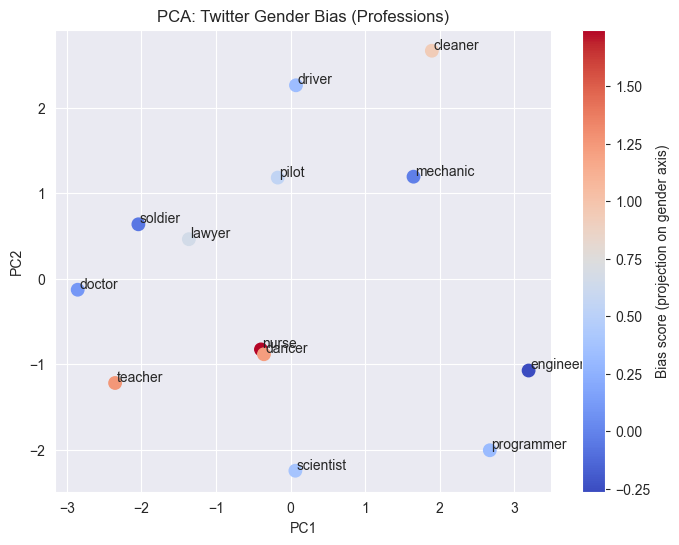


Twitter Embeddings
PC1 alignment with gender direction: -0.0795 (explains 19.41% variance)
PC2 alignment with gender direction: -0.0412 (explains 12.84% variance)


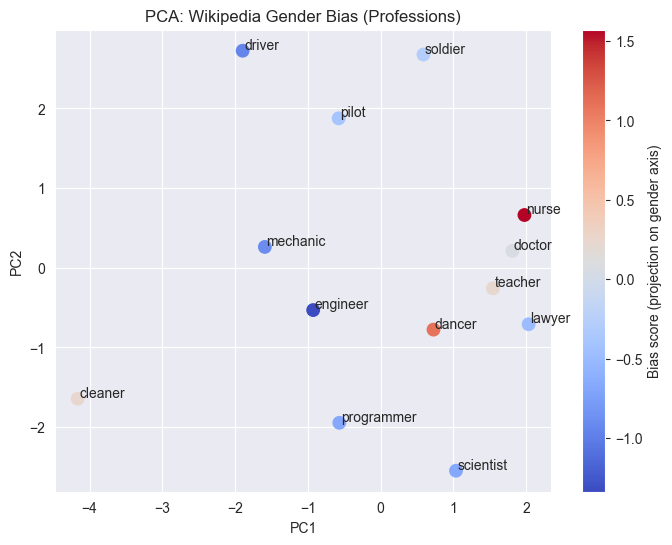


Wikipedia Embeddings
PC1 alignment with gender direction: 0.1617 (explains 18.63% variance)
PC2 alignment with gender direction: -0.0132 (explains 15.16% variance)


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from gensim.models import KeyedVectors

# --- Carica i modelli salvati ---
glove_wiki = KeyedVectors.load("glove-wiki-gigaword-100")
glove_twitter = KeyedVectors.load("glove-twitter-100")

# --- Coppie di genere ---
GENDER_PAIRS = [
    ('woman', 'man'),
    ('girl', 'boy'),
    ('she', 'he'),
    ('mother', 'father'),
    ('sister', 'brother'),
    ('aunt', 'uncle'),
    ('niece', 'nephew'),
    ('daughter', 'son'),
    ('female', 'male'),
    ('her', 'his')
]

# --- Professioni target ---
PROFESSIONS = [
    'doctor', 'nurse', 'engineer', 'teacher', 'programmer', 'scientist',
    'soldier', 'pilot', 'dancer', 'driver', 'mechanic', 'lawyer', 'cleaner'
]


def calculate_bias_direction(embedding_model, pairs):
    """Calcola il vettore di direzione del bias (genere in questo caso)"""
    diffs = []
    for w1, w2 in pairs:
        if w1 in embedding_model and w2 in embedding_model:
            diffs.append(embedding_model[w1] - embedding_model[w2])
    mean_vector = np.mean(diffs, axis=0)
    return mean_vector / np.linalg.norm(mean_vector)


def run_pca(embedding_model, words):
    """Esegue PCA su una lista di parole"""
    vectors = []
    valid_words = []
    for word in words:
        if word in embedding_model:
            vectors.append(embedding_model[word])
            valid_words.append(word)

    vectors = np.array(vectors)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    return reduced, valid_words, pca, vectors


def plot_pca_with_bias(reduced, words, vectors, bias_vector, title):
    """Plot PCA scatter colorando i punti in base al bias score"""
    # Calcola bias score come proiezione sul vettore di bias
    scores = [np.dot(vec, bias_vector) for vec in vectors]

    plt.figure(figsize=(8, 6))
    sc = plt.scatter(reduced[:, 0], reduced[:, 1], c=scores, cmap="coolwarm", s=80)
    for i, word in enumerate(words):
        plt.text(reduced[i, 0] + 0.02, reduced[i, 1] + 0.02, word, fontsize=10)

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(title)
    plt.colorbar(sc, label="Bias score (projection on gender axis)")
    plt.grid(True)
    plt.show()


def check_pca_bias_alignment(pca_model, bias_vector, title):
    """Verifica quanto PC1 e PC2 si allineano con il vettore di bias"""
    components = pca_model.components_[:2]
    bias_proj = [np.dot(bias_vector, pc) for pc in components]
    explained = pca_model.explained_variance_ratio_[:2]

    print(f"\n{title}")
    for i, (proj, var) in enumerate(zip(bias_proj, explained), start=1):
        print(f"PC{i} alignment with gender direction: {proj:.4f} (explains {var * 100:.2f}% variance)")


# --- Twitter embeddings ---
gender_vector_twitter = calculate_bias_direction(glove_twitter, GENDER_PAIRS)
reduced_twitter, valid_words_twitter, pca_twitter, vectors_twitter = run_pca(glove_twitter, PROFESSIONS)
plot_pca_with_bias(reduced_twitter, valid_words_twitter, vectors_twitter, gender_vector_twitter,
                   "PCA: Twitter Gender Bias (Professions)")
check_pca_bias_alignment(pca_twitter, gender_vector_twitter, "Twitter Embeddings")

# --- Wikipedia embeddings ---
gender_vector_wiki = calculate_bias_direction(glove_wiki, GENDER_PAIRS)
reduced_wiki, valid_words_wiki, pca_wiki, vectors_wiki = run_pca(glove_wiki, PROFESSIONS)
plot_pca_with_bias(reduced_wiki, valid_words_wiki, vectors_wiki, gender_vector_wiki,
                   "PCA: Wikipedia Gender Bias (Professions)")
check_pca_bias_alignment(pca_wiki, gender_vector_wiki, "Wikipedia Embeddings")
